In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
tf = pd.read_csv('../../data/events.csv', low_memory=False)

In [ ]:
tf.columns

In [ ]:
tf['staticpage'].value_counts()

In [ ]:
tf['channel'].value_counts()

In [ ]:
tf.head(10)

In [ ]:
tf['campaign_source'].value_counts()

In [ ]:
tf['search_engine'].value_counts()

In [ ]:
# to datetime:

tf['timestamp'] = pd.to_datetime(tf['timestamp'])

In [ ]:
comprados = tf.loc[tf['event'] == 'conversion']

# Agrego col con nombre del dia
comprados['weekday name'] = tf['timestamp'].dt.weekday_name

## Cantidad de compras por dia de la semana

In [ ]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

comprados['weekday name'].value_counts().reindex(days).plot(kind='bar')

## Cantidad total de eventos por horario

In [ ]:
df_hr = tf.filter(items = ['country','timestamp', 'event'])

df_hr['hour'] = df_hr['timestamp'].dt.hour

gr = df_hr['hour'].value_counts(sort=False).plot(kind='line', figsize=(8, 5), grid=True, style="-o")
gr.set_xlabel('Hora (24hs)')
plt.xticks(range(0, 25));

# Analisis de Eventos:

## Cantidad de cada tipo de evento:

In [ ]:
# 5 predominantes:
eventos = tf['event'].value_counts()
eventos.head().plot(kind='bar')

In [ ]:
# Sacando evento 'viewed products':

tf['event'].loc[tf['event'] != 'viewed product'].value_counts().plot(kind='bar')

## Cantidad de eventos totales por pais

In [ ]:
# los 4 predominantes:
# el grafico es feo

df_short = tf.filter(items = ['event', 'country'])
df_short['country'].value_counts().head(4).plot(kind='bar')

## Cantidad de eventos 'viewed product' por mes

In [ ]:
df_event_vp = tf.loc[tf['event'] == 'viewed product' ]
g = df_event_vp.groupby([tf['timestamp'].dt.month, 'event']).size().unstack()\
                        .plot(kind='bar')
g.set_xlabel("Mes")
g.set_ylabel('Cantidad de eventos')
g.legend(['Viewed product'])

## cant ckeckouts >>> cant conversions:

In [ ]:
#mal grafico?
df_event = tf.filter(items = ['event', 'timestamp'])
checkout_vs_conv = df_event.loc[(tf['event'] == 'checkout') | (tf['event'] == 'conversion')]
checkout_vs_conv['event'].value_counts(normalize=True).plot(kind='barh')

## Modelos mas comprados:

In [ ]:
df_event_mod = tf.filter(items = ['event', 'model'])
df_event_mod.loc[df_event_mod['event'] == 'conversion']['model'].value_counts().head().plot(kind='bar')

## Cantidad de comprados por condicion del producto

In [ ]:
comprados = tf.loc[tf['event'] == 'conversion']

qual = ['Novo', 'Excelente', 'Muito Bom', 'Bom', 'Bom - Sem Touch ID']
comprados['condition'].value_counts().reindex(qual).plot(kind='barh')

In [ ]:
# Cantidad de productos (por 'condition') que tenemos en el dataset:

tf['condition'].value_counts().plot(kind='bar')

## Modelos no disponibles con más pedidos de notificación de stock 

In [ ]:
df_event_mod = tf.filter(items = ['event', 'model'])
df_event_mod.loc[df_event_mod['event'] == 'lead']['model'].value_counts().head().plot(kind='bar')

# 'new vs returning' por mes

In [ ]:
df_new_vs_ret = tf.filter(items = ['event', 'new_vs_returning'])
graf = tf.groupby([tf['timestamp'].dt.month, 'new_vs_returning']).size().unstack().plot(kind='bar')
graf.set(xlabel='Numero de mes', ylabel='Cantidad')
graf.legend(['New', 'Returning'])

# Cantidad de visitas por compra de cliente

## Solo los clientes que por lo menos realizaron una compra

In [ ]:
person_event = tf.filter(items=['person', 'event'])
person_event['cant'] = 1
person_event = person_event.loc[(person_event['event'] == 'conversion') | (person_event['event'] == 'viewed product')]

person_conv = person_event.groupby(['person', 'event']).agg({'cant': 'sum'}).unstack()
person_conv = person_conv.loc[(person_conv['cant']['conversion'].notnull()) & (person_conv['cant']['conversion'] != 0)]

In [ ]:
# Cambio nombre columnas
person_conv.columns = ['conversion', 'viewed product']

In [ ]:
person_conv.head()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)

dx = sns.stripplot(x="conversion", y="viewed product", data=person_conv,\
                   jitter=True, linewidth=0.4, alpha=.4, marker=".", size=40, ax=ax)

dx.set(xlabel='Numero de compras', ylabel='Cantidad de visitas', \
       title='Relacion entre numero de compras y cantidad de visitas por usuario');


Cada punto es un cliente (identificado a partir de la columna 'person') que posee una cantidad total de visitas al sitio (cantidad de eventos 'viewed product') y un numero total de compras (cantidad de eventos 'conversion'). En el gráfico solo se muestran los usuarios que realizaron más de una compra.

In [ ]:
g = person_conv['conversion'].value_counts().plot(kind='bar')

g.set(xlabel="Numero de compras", ylabel='Cantidad', title='Cantidad total de compras')


In [ ]:
# los de 1 compra

person_conv1 = person_event.groupby(['person', 'event']).agg({'cant': 'sum'}).unstack()
person_conv1 = person_conv1.loc[(person_conv1['cant']['conversion'].notnull()) & (person_conv1['cant']['conversion'] == 1)]

In [ ]:
person_conv1.columns = ['conversion', 'viewed product']
person_conv1.head()

In [ ]:
person_conv1['viewed product'].value_counts().head(10)

In [ ]:
#g = person_conv1['viewed product'].value_counts().plot().hist()
person_conv1.hist(column='viewed product', xlabelsize=15, bins=19)

- - -

# ¿Cuantos usuarios regresan 'x' cantidad de veces al sitio?

In [ ]:
# No hay registros de personas NaN
tf['person'].isna().sum()

In [ ]:
# Cantidad de usuarios distintos registrados
tf['person'].value_counts().count()

- - -

In [4]:
new_vs_returning = tf.filter(items=['person', 'new_vs_returning'])


# Podemos considerar que todos los valores nulos son registros de usuarios que regresan al sitio ('Returning').
# Luego descartaremos los usuarios que no tienen ningun registro de haber ingresado al sitio por primera vez ('New').

new_vs_returning.fillna({'new_vs_returning': 'Returning'}, inplace=True)

new_vs_returning = new_vs_returning.groupby(['person'])['new_vs_returning'].value_counts(dropna=False)

In [5]:
# Obtengo una serie
new_vs_returning.head()

person    new_vs_returning
0004b0a2  Returning            3
          New                  1
0006a21a  Returning            3
          New                  1
000a54b2  Returning           36
Name: new_vs_returning, dtype: int64

In [6]:
# Construyo un DataFrame
new_vs_returning_df = new_vs_returning.unstack()
new_vs_returning_df.head()

new_vs_returning,New,Returning
person,,
0004b0a2,1.0,3.0
0006a21a,1.0,3.0
000a54b2,1.0,36.0
00184bf9,1.0,50.0
0019c395,1.0,7.0


In [7]:
# Veo cuantos nulos hay en la columna 'New'. Es decir, cuantos usuarios no fueron detectados por primera vez
new_vs_returning_df['New'].value_counts(dropna=False)

 1.0    26898
NaN       726
Name: New, dtype: int64

In [8]:
# Veo cuantos nulos hay en la columna returning
new_vs_returning_df['Returning'].isna().sum()

0

In [9]:
# Elimino los usuarios que no fueron detectados por primera vez:
new_vs_returning_df.dropna(inplace=True)

[Text(0,0.5,'Cantidad de usuarios'),
 Text(0.5,0,'Numero de veces que regresa un usuario a la pagina'),
 Text(0.5,1,'Cuantos usuarios regresan "x" cantidad de veces al sitio')]

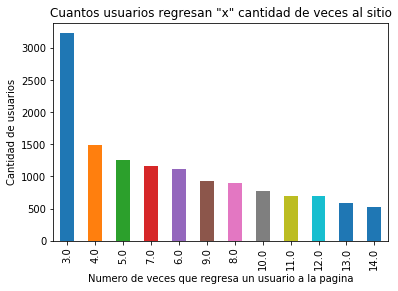

In [10]:
new_vs_returning_g = new_vs_returning_df['Returning'].value_counts().head(12).plot(kind='bar')

new_vs_returning_g.set(xlabel='Numero de veces que regresa un usuario a la pagina', ylabel='Cantidad de usuarios',\
                      title='Cuantos usuarios regresan "x" cantidad de veces al sitio')

---

In [11]:
new_vs_returning = tf.filter(items=['person', 'new_vs_returning'])


# Podemos considerar que todos los valores nulos son registros de usuarios que regresan al sitio ('Returning').
# Luego descartaremos los usuarios que no tienen ningun registro de haber ingresado al sitio por primera vez ('New').

new_vs_returning.fillna({'new_vs_returning': 'Returning'}, inplace=True)

new_vs_returning = new_vs_returning.groupby(['person'])['new_vs_returning'].value_counts(dropna=False)

In [12]:
# Obtengo una serie
new_vs_returning.head()

person    new_vs_returning
0004b0a2  Returning            3
          New                  1
0006a21a  Returning            3
          New                  1
000a54b2  Returning           36
Name: new_vs_returning, dtype: int64

In [13]:
# Construyo un DataFrame
new_vs_returning_df = new_vs_returning.unstack()
new_vs_returning_df.head()

new_vs_returning,New,Returning
person,,
0004b0a2,1.0,3.0
0006a21a,1.0,3.0
000a54b2,1.0,36.0
00184bf9,1.0,50.0
0019c395,1.0,7.0


In [14]:
# Veo cuantos nulos hay en la columna 'New'. Es decir, cuantos usuarios no fueron detectados por primera vez
new_vs_returning_df['New'].value_counts(dropna=False)

 1.0    26898
NaN       726
Name: New, dtype: int64

In [15]:
# Elimino los usuarios que no fueron detectados por primera vez:
new_vs_returning_df.dropna(inplace=True)

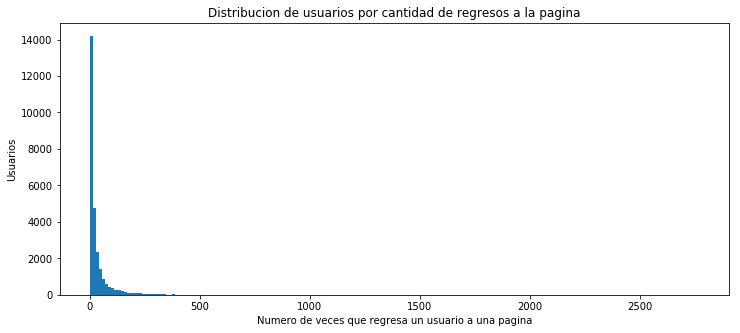

In [81]:
#Si tomamos Todos los valores registrados:

fig, ax = plt.subplots(figsize=(12, 5))

x = new_vs_returning_df['Returning']
g = ax.hist(x, bins=200);

plt.xlabel('Numero de veces que regresa un usuario a una pagina')
plt.ylabel('Usuarios')
plt.title('Distribucion de usuarios por cantidad de regresos a la pagina');

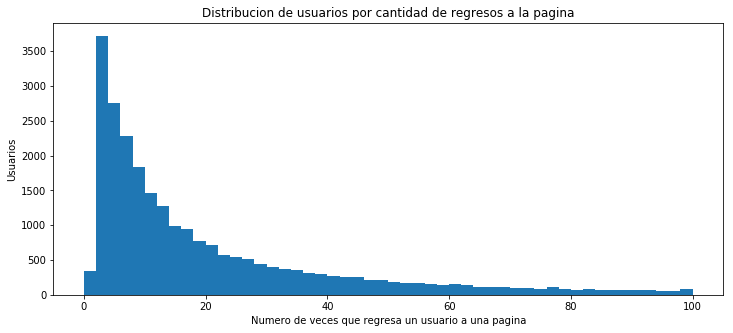

In [63]:
# Restringiendo los valores para una mejor visualizacion y mas especifica:

fig, axs = plt.subplots(figsize=(12, 5))

x = new_vs_returning_df['Returning']
axs.hist(x, bins=50, range=(0,100));

plt.xlabel('Numero de veces que regresa un usuario a una pagina')
plt.ylabel('Usuarios')
plt.title('Distribucion de usuarios por cantidad de regresos a la pagina');

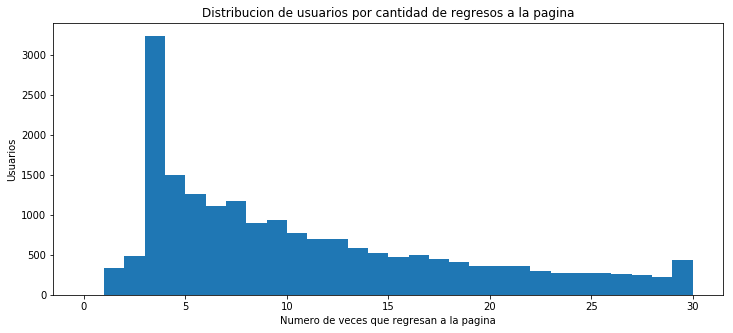

In [80]:
fig, axs = plt.subplots(figsize=(12, 5))

axs.hist(x, bins=30, range=(0,30), label='cfds');

plt.xlabel('Numero de veces que regresan a la pagina')
plt.ylabel('Usuarios')
plt.title('Distribucion de usuarios por cantidad de regresos a la pagina');

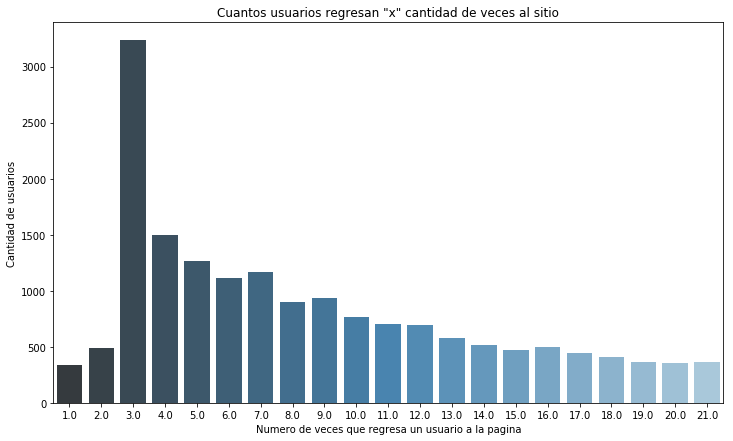

In [83]:
# Grafico de barras para ver detalladamente cuantas veces regresa al sitio la mayoria de los usuarios

fig, ax = plt.subplots(figsize=(12,7))

nums = range(1, 24)

relacion = new_vs_returning_df['Returning'].value_counts(sort=True).head(21)

g = sns.barplot(x=relacion.index, y=relacion.values, palette="Blues_d", orient='v', ax=ax)

g.set(xlabel='Numero de veces que regresa un usuario a la pagina', ylabel='Cantidad de usuarios',\
    title='Cuantos usuarios regresan "x" cantidad de veces al sitio');